In [127]:
## Import data
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sklearn

# PRESSURE_PATH = '/home/ubuntu/CAAM/496_New_Data/pressure/'   # pressure data
# SATURATION_PATH = '/home/ubuntu/CAAM/496_New_Data/saturation/' # saturation data
# PRODUCTION_PATH = '/home/ubuntu/CAAM/496_New_Data/production/' # production data
# ROCK_PATH = '/home/ubuntu/CAAM/496_New_Data/rock/'
PRESSURE_PATH = '/Users/jiujiu/Desktop/496_New_Data/pressure/'   # pressure data
SATURATION_PATH = '/Users/jiujiu/Desktop/496_New_Data/saturation/' # saturation data
PRODUCTION_PATH = '/Users/jiujiu/Desktop/496_New_Data/production/' # production data
ROCK_PATH = '/Users/jiujiu/Desktop/496_New_Data/rock/'

def pullseries(PATH, NAME, index_list):
    # input: NAME - 'saturation' or 'pressure'
    data = []
    for i in index_list:
        temp_data = np.loadtxt(PATH+NAME+str(i)+'.txt',delimiter = ',')
        #temp_data = np.reshape(temp_data,(75,60,220),order ='F')
        data.append(temp_data)
    data = np.float32(data)
    # restructure data into long array (total snapshots , 13200)
    # total snapshots = n X 75
    # 13200 = total grid points = 60 X 220
    data = data.reshape((data.shape[0]*data.shape[1],data.shape[2])) 
    return data

def pullporosity(ROCK_PATH, index_list):
    data = []
    for i in index_list:
        temp_data = np.loadtxt(ROCK_PATH + '/rock'+str(i)+'.txt', delimiter=',')
        data.append(temp_data[[0]])
    data = np.float32(data)
    data = data.reshape((data.shape[0]*data.shape[1],data.shape[2])) 
    return data

def pull_pp(ROCK_PATH, index_list, index):
    data = []
    for i in index_list:
        temp_data = np.loadtxt(ROCK_PATH + '/rock'+str(i)+'.txt', delimiter=',')
        data.append(temp_data[[index]])
    data = np.float32(data)
    data = data.reshape((data.shape[0]*data.shape[1],data.shape[2])) 
    return data

def pull_laststate(PATH,NAME,index_list):
    # input: NAME - 'saturation' or 'pressure'
    data = []
    for i in index_list:
        temp_data = np.loadtxt(PATH+NAME+str(i)+'.txt',delimiter = ',')
        #temp_data = np.reshape(temp_data,(75,60,220),order ='F')
        data.append(temp_data[-1,:])
    data = np.float32(data)
    # restructure data into long array (total snapshots , 13200)
    # total snapshots = n X 75
    # 13200 = total grid points = 60 X 220
    # data = data.reshape((data.shape[0]*data.shape[1],data.shape[2])) 
    return data

# function to compare resulting sequential states
def animate_compare(y1,y2):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    for i in range(len(y1)):    
        ax1.clear()
        ax1.imshow(np.reshape(y1[i,:],(60,220),order ='F'))
        ax2.clear()
        ax2.imshow(np.reshape(y2[i,:],(60,220),order ='F'))
        fig.canvas.draw()
        plt.pause(0.05)
# plt.title('Water Saturation')
# plt.savefig('Saturation Plot X_1.png')

def animate_single(X):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    for i in range(len(X)):    
        ax1.clear()
        ax1.imshow(np.reshape(X[i,:],(60,220),order ='F'))
        fig.canvas.draw()
        plt.pause(0.05)
        
def animate_encoded(X,decoder,index_range):
    # sanity check on stacked encoded space
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()
#     print(X.shape)
    decoded_X = decoder.predict(X[:,:,:,index_range])
#     print(decoded_X)
    for i in range(len(decoded_X)):
        ax1.clear()
        ax1.imshow(np.reshape(decoded_X[i],(60,220),order = 'F'))
        fig.canvas.draw()
        plt.pause(0.01)

def combine_PS(PRESSURE,SATURATION):
    # combine two datasets together
    Z = []
    for i in range(len(PRESSURE)):
        Z.append(np.stack([PRESSURE[i,:],SATURATION[i,:]],axis = -1))
    Z = np.float32(Z)
    return Z

def combine_PPP(PORO,PERM1,PERM2):
    Z = []
    for i in range(len(PORO)):
        Z.append(np.stack([PORO[i,:],PERM1[i,:],PERM2[i,:]],axis = -1))
    Z = np.float32(Z)
    return Z

from sklearn import preprocessing
def scale_inputs(TRAIN,TEST):
    scaler = preprocessing.MinMaxScaler()
    TRAIN = scaler.fit_transform(TRAIN)
    TEST = scaler.transform(TEST)
    return TRAIN,TEST

def scale_outputs(TRAIN,TEST):
    scaler = preprocessing.MinMaxScaler()
    TRAIN = scaler.fit_transform(TRAIN)
    TEST = scaler.transform(TEST)
    return TRAIN,TEST,scaler


In [4]:
# Specify files to read for testing and training
train_files = np.arange(1,81)
test_files = np.arange(81,101)

In [14]:
# pull outputs
STRAIN = pull_laststate(SATURATION_PATH, 'saturaton', train_files)
STEST = pull_laststate(SATURATION_PATH, 'saturaton', test_files)

PTRAIN = pull_laststate(PRESSURE_PATH, 'pressure', train_files)
PTEST = pull_laststate(PRESSURE_PATH, 'pressure', test_files)

In [128]:
# pull inputs
Poro_TRAIN = pull_pp(ROCK_PATH, train_files, 0)
Poro_TEST = pull_pp(ROCK_PATH, test_files, 0)
perm_1_TRAIN = pull_pp(ROCK_PATH, train_files, 1)
perm_1_TEST = pull_pp(ROCK_PATH, test_files, 1)
perm_2_TRAIN = pull_pp(ROCK_PATH, train_files, 2)
perm_2_TEST = pull_pp(ROCK_PATH, test_files, 2)

In [169]:
min_perm1 = perm_1_TRAIN.max()
print(min_perm1)

1.9738e-11


In [129]:
# # scale inputs
# Poro_TRAIN_scaled,Poro_TEST_scaled = scale_inputs(Poro_TRAIN,Poro_TEST)
# perm_1_TRAIN_scaled,perm_1_TEST_scaled = scale_inputs(perm_1_TRAIN,perm_1_TEST)
# perm_2_TRAIN_scaled,perm_2_TEST_scaled = scale_inputs(perm_2_TRAIN,perm_2_TEST)

In [155]:
# animate_compare(STRAIN_scaled[1:5,:],STRAIN[1:5,:])
print(STRAIN_scaled.min(axis=0),STRAIN_scaled.min(axis=0).shape)
print(STRAIN_scaled.shape)

[0. 0. 0. ... 0. 0. 0.] (13200,)
(80, 13200)


In [65]:
# scale outputs
STRAIN_scaled, STEST_scaled, SScaler = scale_outputs(STRAIN,STEST)
PTRAIN_scaled, PTEST_scaled, PScaler = scale_outputs(PTRAIN,PTEST)

In [156]:
TRAIN_X = combine_PPP(Poro_TRAIN_scaled,perm_1_TRAIN_scaled,perm_2_TRAIN_scaled)
TEST_X = combine_PPP(Poro_TEST_scaled,perm_1_TEST_scaled,perm_2_TEST_scaled)


TRAIN_Y = combine_PS(PTRAIN_scaled,STRAIN_scaled)
TEST_Y = combine_PS(PTEST_scaled,STEST_scaled)

STRAIN_Y = np.expand_dims(STRAIN_scaled, axis=-1)
STEST_Y = np.expand_dims(STEST_scaled, axis=-1)

<IPython.core.display.Javascript object>


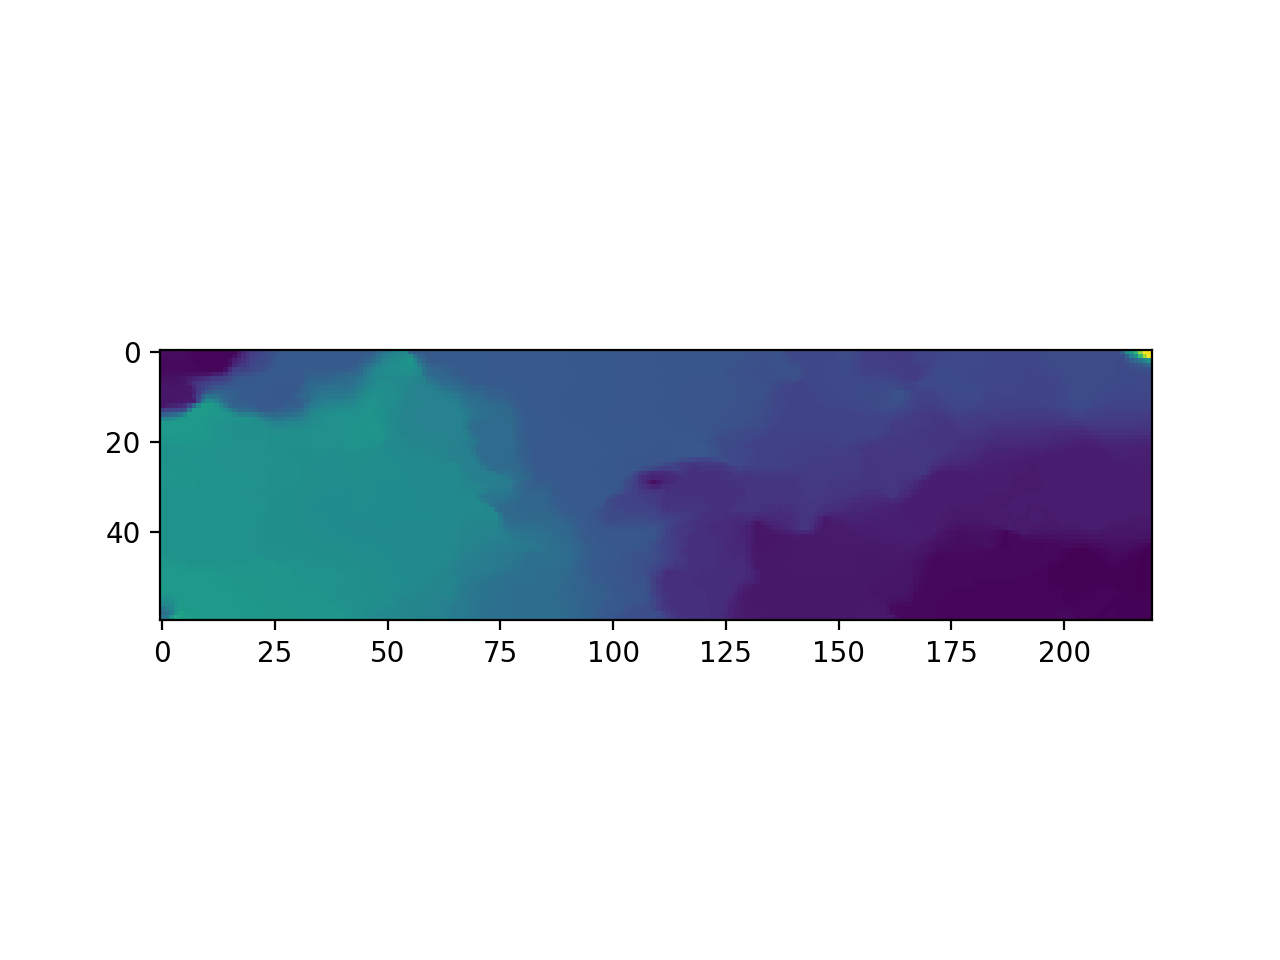

In [97]:
animate_single(TRAIN_Y[1:5,:,0])

<IPython.core.display.Javascript object>


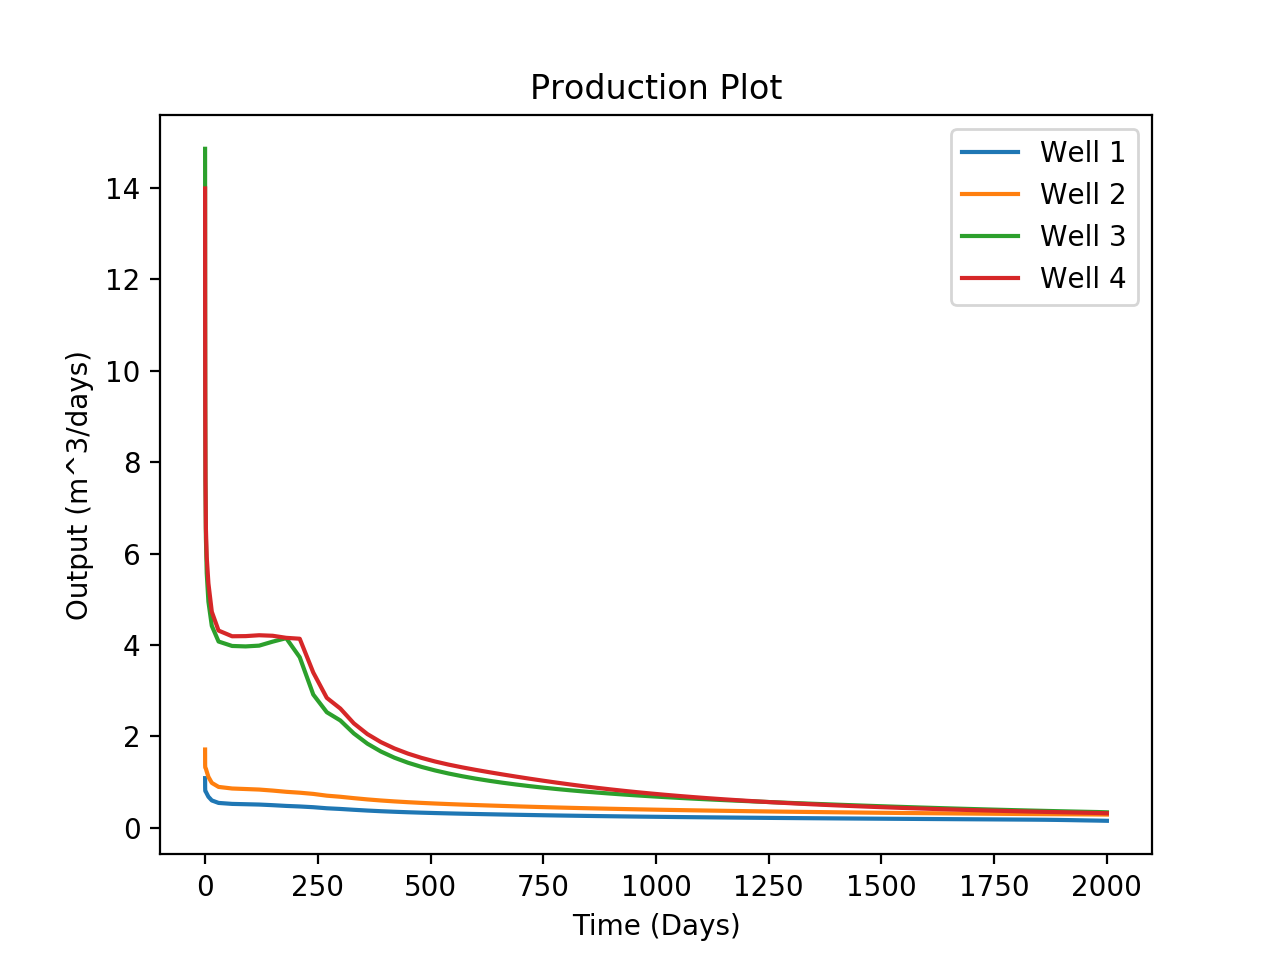

In [3]:
# check production data
Prod_unsized = np.loadtxt(PRODUCTION_PATH + 'production2.txt')
Prod_resized = np.array([Prod_unsized[:,0]/3600.0/24.0, 
                         Prod_unsized[:,1]*3600*24,
                         Prod_unsized[:,2]*3600*24,
                         Prod_unsized[:,3]*3600*24,
                         Prod_unsized[:,4]*3600*24])
well_1 = plt.plot(Prod_resized[0,],Prod_resized[1,],label='Well 1')
well_2 = plt.plot(Prod_resized[0,],Prod_resized[2,],label='Well 2')
well_3 = plt.plot(Prod_resized[0,],Prod_resized[3,],label='Well 3')
well_4 = plt.plot(Prod_resized[0,],Prod_resized[4,],label='Well 4')
plt.title('Production Plot')
# plt.yscale('log')
plt.xlabel('Time (Days)')
plt.ylabel('Output (m^3/days)')
plt.legend()
plt.savefig('Production Plot2.png')

In [152]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape
from keras.regularizers import l1
from keras.models import Model
from keras import backend as K
from keras.models import load_model
from keras.callbacks import TensorBoard
# the constructer will instantiate the model as specified 
# (one model for each type of data)
def construct_autoencoder_model(channels_numbers):
    # tuple channel_numebers contain the channel numbers for 3 convolutional layers
    # default should be 16,12,8 
    regularizer_strength = 1e-6
    input_img = Input(shape=(13200,3))  # y, x
    x = Reshape((60,220, 3))(input_img)
    x = Conv2D(channels_numbers[0], (3, 3), activation='relu', padding="same",activity_regularizer=l1(regularizer_strength))(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(channels_numbers[1], (3, 3), activation='relu', padding='same',activity_regularizer=l1(regularizer_strength))(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(channels_numbers[2], (3, 3), activation='relu', padding='same',activity_regularizer=l1(regularizer_strength))(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    # encoded space (6, 11, ?)
    x = Conv2D(channels_numbers[2], (3, 3), activation='relu', padding='same',activity_regularizer=l1(regularizer_strength))(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(channels_numbers[1], (3, 3), activation='relu', padding='same',activity_regularizer=l1(regularizer_strength))(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(channels_numbers[0], (3, 3), activation='relu', padding='valid',activity_regularizer=l1(regularizer_strength))(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same',activity_regularizer=l1(regularizer_strength))(x)
    decoded = Reshape((13200,1))(x)
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    encoded_shape = autoencoder.layers[7].output.shape[1:]
    encoded_shape = tuple([int(encoded_shape[i]) for i in range(len(encoded_shape)) ])
#     autoencoder.summary()
    return autoencoder, encoded_shape

In [153]:
autoencoder,encoded_shape = construct_autoencoder_model([32,16,16])
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 13200, 3)          0         
_________________________________________________________________
reshape_11 (Reshape)         (None, 60, 220, 3)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 60, 220, 32)       896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 30, 110, 32)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 30, 110, 16)       4624      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 15, 55, 16)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 15, 55, 16)        2320      
__________

In [140]:
def train_autoencoder(model, iterations, TRAIN, TEST, name):
    # names: R for porosity, P for pressure, S for saturation
    
    model.fit(TRAIN[0], TRAIN[1],
                epochs = iterations,
                batch_size = 10,
                shuffle=True,
                validation_data=(TEST[0], TEST[1]),
                verbose = 1)
    model.save(name+'autoencoder.h5')
    return model

In [157]:
autoencoder = train_autoencoder(autoencoder, 10, (TRAIN_X,STRAIN_Y), (TEST_X,STEST_Y), 'TASK3_')

Train on 80 samples, validate on 20 samples
Epoch 1/10
80/80 [==============================] - 12s 153ms/step - loss: 1.3985 - val_loss: 1.3101
Epoch 2/10
80/80 [==============================] - 9s 116ms/step - loss: 1.2448 - val_loss: 1.2073
Epoch 3/10
80/80 [==============================] - 9s 118ms/step - loss: 1.1557 - val_loss: 1.1239
Epoch 4/10
80/80 [==============================] - 9s 114ms/step - loss: 1.0788 - val_loss: 1.0515
Epoch 5/10
80/80 [==============================] - 9s 111ms/step - loss: 1.0141 - val_loss: 0.9882
Epoch 6/10
80/80 [==============================] - 9s 114ms/step - loss: 0.9548 - val_loss: 0.9327
Epoch 7/10
80/80 [==============================] - 9s 116ms/step - loss: 0.9030 - val_loss: 0.8838
Epoch 8/10
80/80 [==============================] - 9s 114ms/step - loss: 0.8590 - val_loss: 0.8447
Epoch 9/10
80/80 [==============================] - 9s 113ms/step - loss: 0.8236 - val_loss: 0.8130
Epoch 10/10
80/80 [==============================] - 9s

In [158]:
temp = autoencoder.predict(TRAIN_X[5:10,])

(5, 13200, 1)
(5, 13200, 1)


<IPython.core.display.Javascript object>


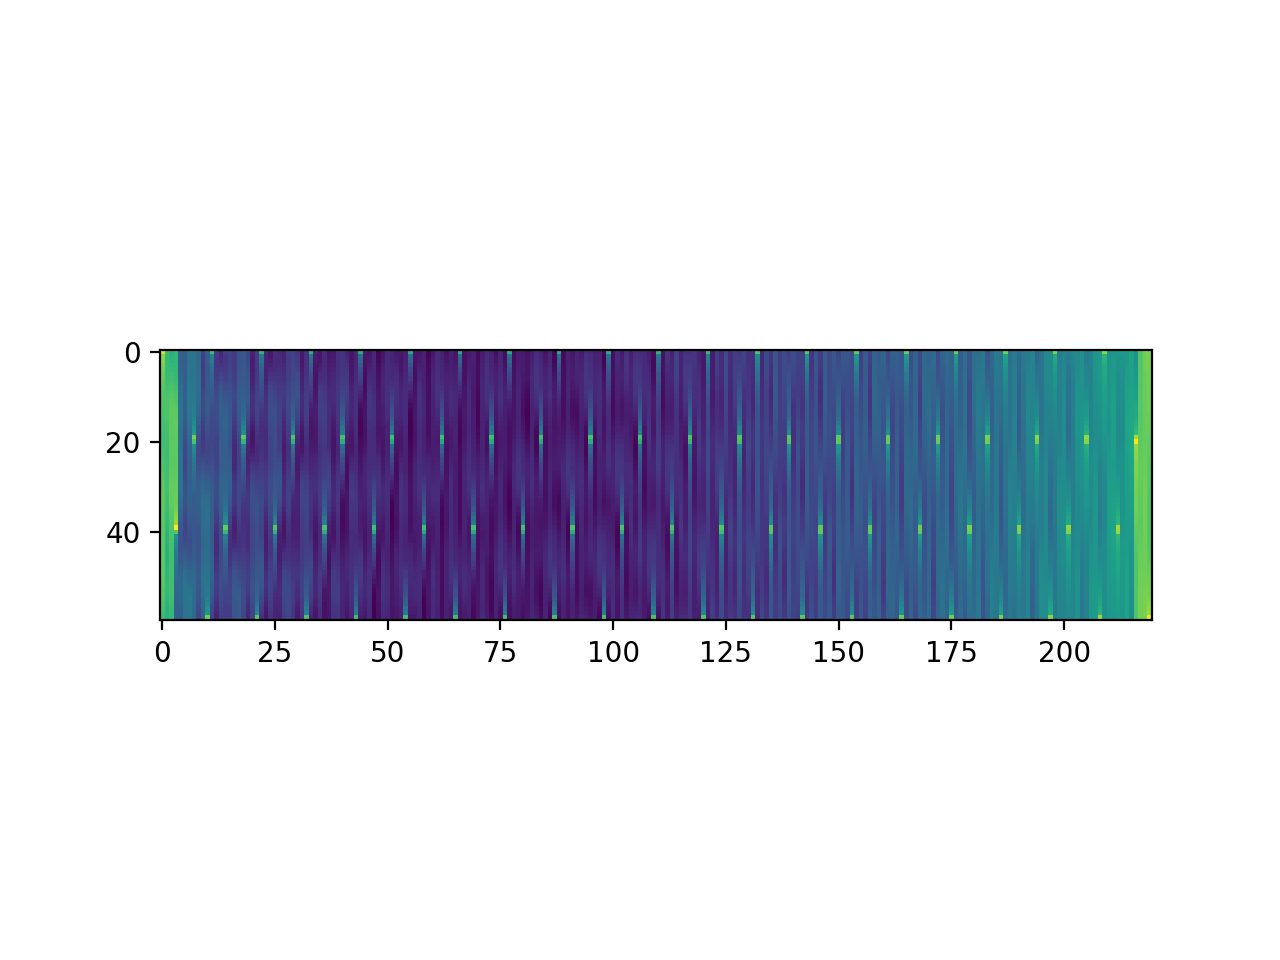

In [165]:
print(temp.shape)
predicted_s = temp[:,:]
print(predicted_s.shape)
animate_single(predicted_s[:,:])
predicted_s = SScaler.inverse_transform(predicted_s[:,:,0])



<IPython.core.display.Javascript object>


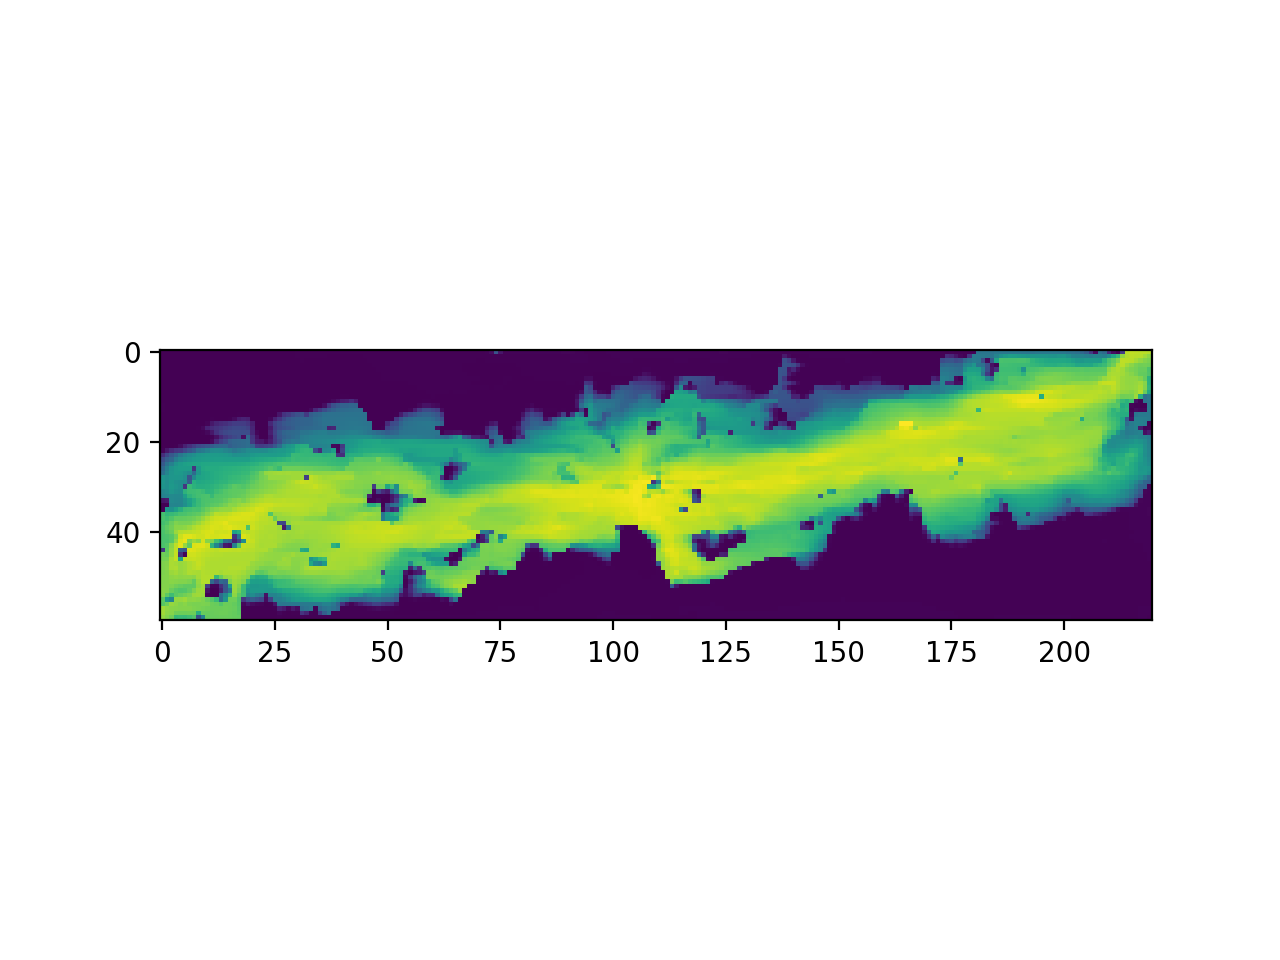

In [123]:
animate_single(TRAIN_Y[:,:,1])